In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 4.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional, ConvLSTM2D, BatchNormalization, Flatten
from tensorflow.keras.regularizers import l2

In [ ]:
print(tf.__version__)

2.15.0


# 数据清洗


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#reading processed data of Fars
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ireland/Test_Ireland.csv')
df['time'] = pd.to_datetime(df['time'], format='%Y/%m/%d/%H/%M')
df.head(10)


,longitude,latitude,time,u10,v10,d2m,t2m,e,mx2t,mn2t,sp,tcc,tp
0,5.3,55.3,2020-09-01 00:00:00,-4.191816,0.428391,284.591893,290.271387,-0.000069,290.333333,290.282176,102029.1092,0.254118,0.000011
1,5.3,55.3,2020-09-01 01:00:00,-4.462841,1.907467,284.305642,290.321154,-0.000096,290.495217,290.362821,102023.3408,0.312440,0.000021
2,5.3,55.3,2020-09-01 02:00:00,-4.277536,3.010832,284.443043,290.316630,-0.000120,290.508948,290.354829,102024.4945,0.375768,0.000049
3,5.3,55.3,2020-09-01 03:00:00,-4.179211,3.655286,284.538078,290.309843,-0.000132,290.428729,290.343205,102026.8018,0.212429,0.000039
4,5.3,55.3,2020-09-01 04:00:00,-4.269342,3.719336,283.954125,290.232930,-0.000152,290.334056,290.264012,102050.4521,0.084477,0.000008
5,5.3,55.3,2020-09-01 05:00:00,-4.369558,3.041206,282.753015,290.006713,-0.000190,290.131701,290.034427,102054.6823,0.036257,0.000000
6,5.3,55.3,2020-09-01 06:00:00,-3.628967,1.560809,282.503976,288.616989,-0.000155,288.983339,288.800770,102058.5279,0.011323,0.000000
7,5.3,55.3,2020-09-01 07:00:00,-1.973195,0.021645,280.679982,283.355943,-0.000034,285.559212,284.930514,101843.9444,0.001679,0.000000
8,5.3,55.3,2020-09-01 08:00:00,-1.941680,-1.124639,280.095457,281.498703,-0.000011,283.887619,283.292176,101696.8509,0.000000,0.000000
9,5.3,55.3,2020-09-01 09:00:00,-1.787259,-1.789563,282.120399,284.932673,-0.000066,285.970425,285.785647,101812.9875,0.000000,0.000000


In [ ]:
df.drop(['longitude', 'latitude'], axis=1, inplace=True)
df.shape

(524112, 11)

In [ ]:
for col in df.columns:

  # Checking if the column contains
  # any null values
  if df[col].isnull().sum() > 0:
    val = df[col].mean()
    df[col] = df[col].fillna(val)

df.isnull().sum().sum()

X, y = df.iloc[:, 1:], df.iloc[:, 0]
X_norm = StandardScaler().fit_transform(X)
X_norm.shape

(524112, 10)

          time       u10       v10       d2m       t2m         e      mx2t  \
time  1.000000 -0.019168  0.008366  0.011667  0.008103  0.023659  0.007025   
u10  -0.019168  1.000000  0.180366  0.154693  0.044900 -0.136071  0.033245   
v10   0.008366  0.180366  1.000000  0.199346  0.065695 -0.002166  0.063442   
d2m   0.011667  0.154693  0.199346  1.000000  0.648302 -0.050683  0.649933   
t2m   0.008103  0.044900  0.065695  0.648302  1.000000 -0.420829  0.981790   
e     0.023659 -0.136071 -0.002166 -0.050683 -0.420829  1.000000 -0.349823   
mx2t  0.007025  0.033245  0.063442  0.649933  0.981790 -0.349823  1.000000   
mn2t  0.007571  0.041606  0.067984  0.662354  0.982234 -0.367774  0.994505   
sp   -0.004021  0.049198 -0.205400  0.174500  0.148602 -0.184521  0.138405   
tcc  -0.000034  0.088351  0.139361  0.042529 -0.200699 -0.013904 -0.244261   
tp    0.016054  0.160183  0.155549  0.129368 -0.032820 -0.098364 -0.043955   

          mn2t        sp       tcc        tp  
time  0.007571 -

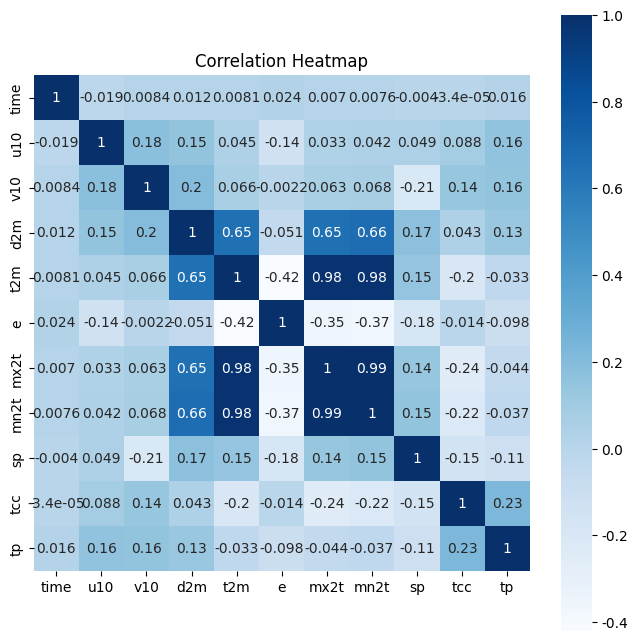

In [ ]:
#计算月度皮尔森相关系数矩阵，包含了任意两个数据间的相关系数
cor_pearson = df.corr(method='pearson')
print(cor_pearson)  # 输出相关系数

#绘制相关性热力图
plt.subplots(figsize=(8, 8)) #设置画面大小
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
sns.heatmap(cor_pearson, annot=True, vmax=1, square=True, cmap="Blues")
plt.title('Correlation Heatmap')
plt.show()

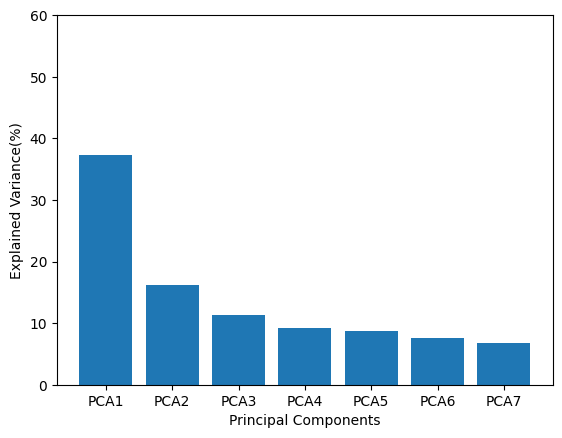

In [ ]:
#PCA库
pca=PCA(n_components=7)
pca.fit(X_norm)
variance_ratios = pca.explained_variance_ratio_
variance_ratios
plt.bar(range(1, len(variance_ratios) + 1), [var*100 for var in variance_ratios])
plt.xticks(range(1, len(variance_ratios) + 1), ['PCA' + str(i) for i in range(1, len(variance_ratios) + 1)])
plt.ylim(0, 60)
plt.ylabel('Explained Variance(%)')
plt.xlabel('Principal Components')
plt.show()
X_pca = pca.transform(X_norm)

In [ ]:
# 将日期时间类型转换为时间戳（数值类型）
df['timestamp'] = pd.to_datetime(df['time']).view('int64')  # 转换为纳秒时间戳

df.dropna(inplace=True)  # 去除NaN值

# 区分特征和目标变量
X = df[['timestamp', 'u10', 'v10', 'd2m', 't2m', 'e', 'mx2t', 'mn2t', 'sp', 'tcc']]
y = df['tp']

# 确认样本数量一致
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# 数据标准化
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# PCA降维
X_pca = PCA(n_components=7)  # 保留99%的方差
X_pca_scaled = pca.fit_transform(X_scaled)

X_pca_scaled
# # 窗口化数据
# window_size = 7
# X_windowed = []
# y_windowed = []
# for i in range(len(X_pca_scaled) - window_size):
#     X_windowed.append(X_pca_scaled[i:i + window_size])
#     y_windowed.append(y.iloc[i + window_size])

# X_windowed = np.array(X_windowed)
# y_windowed = np.array(y_windowed)

# # 确认窗口化后的样本数量
# print(f"X_windowed shape: {X_windowed.shape}")
# print(f"y_windowed shape: {y_windowed.shape}")

# # 分割数据集为训练集和测试集
# tscv = TimeSeriesSplit(n_splits=3)
# for train_index, test_index in tscv.split(X_windowed):
#     X_train, X_test = X_windowed[train_index], X_windowed[test_index]
#     y_train, y_test = y_windowed[train_index], y_windowed[test_index]

X shape: (524112, 10)
y shape: (524112,)


array([[ 2.37278805,  2.03854702, -0.78682748, ..., -0.73101453,
        -0.49309639,  1.24923225],
       [ 2.48426665,  1.64084076, -0.6334104 , ..., -0.30456747,
        -0.378836  ,  1.77165895],
       [ 2.60091548,  1.21418115, -0.39084149, ..., -0.03026456,
        -0.33605515,  2.09849984],
       ...,
       [-0.65296717, -3.35422575, -0.99991342, ...,  1.69909458,
         1.02637348, -0.21307386],
       [-1.12029286, -3.12292991, -1.27357005, ...,  1.54234072,
         0.91858818, -0.38385744],
       [-0.6373572 , -2.2183217 , -1.03200911, ...,  1.20582512,
         0.24827474,  0.00985969]])

# RNN


In [ ]:
# # 创建 RNN 模型函数
# def create_rnn_model(input_shape):
#     model = Sequential()
#     model.add(SimpleRNN(100, activation='relu', return_sequences=True, input_shape=input_shape))
#     model.add(Dropout(0.2))
#     model.add(SimpleRNN(100, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(1))  # 输出层，预测一个连续值
#     return model

# # 数据准备：调整输入形状，适配RNN的输入
# X_pca_reshaped = X_pca.reshape((X_pca.shape[0], X_pca.shape[1], 1))  # 增加一个维度，(样本数, 时间步长, 特征数)

# # 初始化RNN模型
# input_shape = (X_pca_reshaped.shape[1], X_pca_reshaped.shape[2])
# model = create_rnn_model(input_shape)

# # 编译模型
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# rmse_scores = []
# r2_scores_train = []
# r2_scores_test = []
# train_rmse_scores = []  # 添加存储 Train RMSE 的列表

# for train_index, test_index in tscv.split(X_pca_reshaped):
#     X_train, X_test = X_pca_reshaped[train_index], X_pca_reshaped[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # 训练模型
#     early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
#     model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.1, callbacks=[early_stopping])

#     # 预测
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)

#     # 计算 RMSE 和 R² 分数
#     train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
#     test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
#     train_r2 = r2_score(y_train, y_train_pred)
#     test_r2 = r2_score(y_test, y_test_pred)

#     # 保存分数
#     train_rmse_scores.append(train_rmse)  # 保存 Train RMSE
#     rmse_scores.append(test_rmse)
#     r2_scores_train.append(train_r2)
#     r2_scores_test.append(test_r2)

# # 输出平均 RMSE 和 R² 分数
# print(f"Average Train RMSE: {np.mean(train_rmse_scores)}")
# print(f"Average Test RMSE: {np.mean(rmse_scores)}")
# print(f"Average Train R²: {np.mean(r2_scores_train)}")
# print(f"Average Test R²: {np.mean(r2_scores_test)}")

# **LSTM**

在这部分代码中，X_windowed是基于过去window_size（这里是7）的数据，y_windowed 是窗口之后的那个时间点的数据。这意味着模型的输入是过去7个时间点的特征，而输出是第8个时间点的目标值y。
输入：过去 7 个小时的气象数据。
输出：第 8 个小时的降水量。

In [ ]:
# # 构建LSTM模型
# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(window_size, X_pca_scaled.shape[1])))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(1))

# # 编译模型
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# # 训练模型
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# # 评估模型
# train_loss = model.evaluate(X_train, y_train)
# test_loss = model.evaluate(X_test, y_test)
# print(f'Train Loss: {train_loss}')
# print(f'Test Loss: {test_loss}')

# # 预测
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# train_r2 = r2_score(y_train, y_train_pred)
# test_r2 = r2_score(y_test, y_test_pred)


# print(f'Train: {train_r2}')
# print(f'Test: {test_r2}')

# # 计算 RMSE
# train_mse = mean_squared_error(y_train, y_train_pred)
# train_rmse = np.sqrt(train_mse)

# test_mse = mean_squared_error(y_test, y_test_pred)
# test_rmse = np.sqrt(test_mse)

# print(f'Train RMSE: {train_rmse}')
# print(f'Test RMSE: {test_rmse}')

# BiLSTM



In [ ]:
# # 构建BiLSTM模型
# model = Sequential()
# model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(window_size, X_pca_scaled.shape[1])))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(50)))
# model.add(Dropout(0.2))
# model.add(Dense(1))

# # 编译模型
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# # 训练模型
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# # 评估模型
# train_loss = model.evaluate(X_train, y_train)
# test_loss = model.evaluate(X_test, y_test)
# print(f'Train Loss: {train_loss}')
# print(f'Test Loss: {test_loss}')

# # 预测
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# # 计算 R² 分数
# train_r2 = r2_score(y_train, y_train_pred)
# test_r2 = r2_score(y_test, y_test_pred)

# print(f'Train R²: {train_r2}')
# print(f'Test R²: {test_r2}')

# # 计算 RMSE
# train_mse = mean_squared_error(y_train, y_train_pred)
# train_rmse = np.sqrt(train_mse)

# test_mse = mean_squared_error(y_test, y_test_pred)
# test_rmse = np.sqrt(test_mse)

# print(f'Train RMSE: {train_rmse}')
# print(f'Test RMSE: {test_rmse}')

# BiLSTM 100



In [ ]:
# # 构建BiLSTM模型
# model = Sequential()
# model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(window_size, X_pca_scaled.shape[1])))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(100)))
# model.add(Dropout(0.3))
# model.add(Dense(1))

# # 编译模型
# optimizer = Adam(learning_rate=0.0005)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# # 训练模型
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# # 评估模型
# train_loss = model.evaluate(X_train, y_train)
# test_loss = model.evaluate(X_test, y_test)
# print(f'Train Loss: {train_loss}')
# print(f'Test Loss: {test_loss}')

# # 预测
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# # 计算 R² 分数
# train_r2 = r2_score(y_train, y_train_pred)
# test_r2 = r2_score(y_test, y_test_pred)

# print(f'Train R²: {train_r2}')
# print(f'Test R²: {test_r2}')

# # 计算 RMSE
# train_mse = mean_squared_error(y_train, y_train_pred)
# train_rmse = np.sqrt(train_mse)

# test_mse = mean_squared_error(y_test, y_test_pred)
# test_rmse = np.sqrt(test_mse)

# print(f'Train RMSE: {train_rmse}')
# print(f'Test RMSE: {test_rmse}')

# BU-LSTM

In [ ]:
# # 构建结合 Bi-LSTM 和 UI-LSTM 的模型
# model = Sequential()

# # 添加 Bi-LSTM 层来处理双向时间依赖
# model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(window_size, X_pca_scaled.shape[1])))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(50)))
# model.add(Dropout(0.3))

# # UI-LSTM 部分 - 输出均值和方差两个值，进行不确定性估计
# model.add(Dense(2))  # 输出 2 个值：均值和方差（预测值和不确定性）

# # 编译模型，自定义损失函数可以处理不确定性
# optimizer = Adam(learning_rate=0.0005)
# model.compile(optimizer=optimizer, loss='mean_squared_error')  # 简化为MSE，也可以用自定义损失函数

# # 训练模型
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# # 评估模型
# train_loss = model.evaluate(X_train, y_train)
# test_loss = model.evaluate(X_test, y_test)
# print(f'Train Loss: {train_loss}')
# print(f'Test Loss: {test_loss}')

# # 预测时输出均值和方差
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# # 分离均值和方差
# y_train_mean = y_train_pred[:, 0]  # 均值部分
# y_train_variance = y_train_pred[:, 1]  # 方差部分，用于不确定性

# y_test_mean = y_test_pred[:, 0]
# y_test_variance = y_test_pred[:, 1]

# # 计算 R² 分数，只用均值计算
# train_r2 = r2_score(y_train, y_train_mean)
# test_r2 = r2_score(y_test, y_test_mean)

# print(f'Train R²: {train_r2}')
# print(f'Test R²: {test_r2}')

# # 计算 RMSE，只用均值计算
# train_mse = mean_squared_error(y_train, y_train_mean)
# train_rmse = np.sqrt(train_mse)

# test_mse = mean_squared_error(y_test, y_test_mean)
# test_rmse = np.sqrt(test_mse)

# print(f'Train RMSE: {train_rmse}')
# print(f'Test RMSE: {test_rmse}')

# # 不确定性估计：方差可以用于构建预测置信区间
# # 例如：可以使用 ± 1.96 * sqrt(variance) 来构建 95% 置信区间

# BU-LSTM100


In [ ]:
# 构建结合 Bi-LSTM 和 UI-LSTM 的模型
model = Sequential()

# 添加 Bi-LSTM 层来处理双向时间依赖
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(window_size, X_pca_scaled.shape[1])))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))

# UI-LSTM 部分 - 输出均值和方差两个值，进行不确定性估计
model.add(Dense(2, kernel_regularizer=l2(0.001)))  # L2 正则化系数为 0.001

# 编译模型，自定义损失函数可以处理不确定性
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')  # 简化为MSE，也可以用自定义损失函数

# 训练模型
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# 评估模型
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# 预测时输出均值和方差
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 分离均值和方差
y_train_mean = y_train_pred[:, 0]  # 均值部分
y_train_variance = y_train_pred[:, 1]  # 方差部分，用于不确定性

y_test_mean = y_test_pred[:, 0]
y_test_variance = y_test_pred[:, 1]

# 计算 R² 分数，只用均值计算
train_r2 = r2_score(y_train, y_train_mean)
test_r2 = r2_score(y_test, y_test_mean)

print(f'Train R²: {train_r2}')
print(f'Test R²: {test_r2}')

# 计算 RMSE，只用均值计算
train_mse = mean_squared_error(y_train, y_train_mean)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(y_test, y_test_mean)
test_rmse = np.sqrt(test_mse)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# 不确定性估计：方差可以用于构建预测置信区间
# 例如：可以使用 ± 1.96 * sqrt(variance) 来构建 95% 置信区间

Epoch 1/100
4914/4914 [==============================] - 119s 23ms/step - loss: 4.1743e-04 - val_loss: 4.7082e-08
Epoch 2/100
4914/4914 [==============================] - 111s 23ms/step - loss: 4.2877e-08 - val_loss: 5.0780e-08
Epoch 3/100
4914/4914 [==============================] - 113s 23ms/step - loss: 7.0295e-08 - val_loss: 1.0698e-07
Epoch 4/100
4914/4914 [==============================] - 111s 22ms/step - loss: 7.2886e-08 - val_loss: 6.2078e-08
Epoch 5/100
4914/4914 [==============================] - 111s 23ms/step - loss: 6.8218e-08 - val_loss: 8.7623e-08
Epoch 6/100
4914/4914 [==============================] - 112s 23ms/step - loss: 6.6123e-08 - val_loss: 6.0030e-08
Epoch 7/100
4914/4914 [==============================] - 111s 23ms/step - loss: 6.3850e-08 - val_loss: 6.6209e-08
Epoch 8/100
4914/4914 [==============================] - 112s 23ms/step - loss: 6.3137e-08 - val_loss: 6.0216e-08
Epoch 9/100
4914/4914 [==============================] - 110s 22ms/step - loss: 6.1273e-

In [ ]:
# 置信区间因子 (Z = 1.96 对应 95% 的置信区间)
Z = 1.96

# 计算训练集和测试集的置信区间
train_ci_upper = y_train_mean + Z * np.sqrt(y_train_variance)
train_ci_lower = y_train_mean - Z * np.sqrt(y_train_variance)

test_ci_upper = y_test_mean + Z * np.sqrt(y_test_variance)
test_ci_lower = y_test_mean - Z * np.sqrt(y_test_variance)

# 输出训练集和测试集的置信区间
print("Training Set 95% Confidence Interval (Upper, Lower):")
for upper, lower in zip(train_ci_upper, train_ci_lower):
    print(f"Upper: {upper}, Lower: {lower}")

print("Test Set 95% Confidence Interval (Upper, Lower):")
for upper, lower in zip(test_ci_upper, test_ci_lower):
    print(f"Upper: {upper}, Lower: {lower}")

Training Set 95% Confidence Interval (Upper, Lower):
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Upper: nan, Lower: nan
Uppe

<ipython-input-22-675aec486e2e>:5: RuntimeWarning: invalid value encountered in sqrt
  train_ci_upper = y_train_mean + Z * np.sqrt(y_train_variance)
<ipython-input-22-675aec486e2e>:6: RuntimeWarning: invalid value encountered in sqrt
  train_ci_lower = y_train_mean - Z * np.sqrt(y_train_variance)
<ipython-input-22-675aec486e2e>:8: RuntimeWarning: invalid value encountered in sqrt
  test_ci_upper = y_test_mean + Z * np.sqrt(y_test_variance)
<ipython-input-22-675aec486e2e>:9: RuntimeWarning: invalid value encountered in sqrt
  test_ci_lower = y_test_mean - Z * np.sqrt(y_test_variance)


流式输出内容被截断，只能显示最后 5000 行内容。
Upper: 0.03469441831111908, Lower: -0.034078821539878845
Upper: 0.035946574062108994, Lower: -0.03528616204857826
Upper: 0.037596702575683594, Lower: -0.03687486797571182
Upper: 0.03886948525905609, Lower: -0.038098447024822235
Upper: 0.03954918682575226, Lower: -0.03875121474266052
Upper: 0.03901967406272888, Lower: -0.03824272006750107
Upper: 0.03572350740432739, Lower: -0.03507118672132492
Upper: 0.03224668651819229, Lower: -0.03171422332525253
Upper: 0.02899409458041191, Lower: -0.028562918305397034
Upper: 0.03283911198377609, Lower: -0.032287076115608215
Upper: 0.034404732286930084, Lower: -0.03379928320646286
Upper: 0.03510348126292229, Lower: -0.03447341546416283
Upper: 0.035576969385147095, Lower: -0.034929946064949036
Upper: 0.03630450367927551, Lower: -0.03563099354505539
Upper: 0.03692776709794998, Lower: -0.0362311527132988
Upper: 0.037025123834609985, Lower: -0.036324866116046906
Upper: 0.03465395048260689, Lower: -0.034039776772260666
Upper: 0.0